# Binary Classification Model for Loan Default Dataset Using TensorFlow
### David Lowe
### February 10, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Loan Default dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: The dataset owner leveraged another source from Kaggle to create a dataset for predicting loan default. The dataset contains the past data on the loan borrowers, and we would develop a machine learning model to classify whether any new borrower is likely to default.

ANALYSIS: The performance of the preliminary TensorFlow model achieved a ROC/AUC benchmark of 1.0. When we processed the test dataset with the final model, the model achieved a ROC/AUC score of 1.0.

CONCLUSION: In this iteration, the TensorFlow model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Loan Default Dataset by M Yasser H

Dataset ML Model: Binary classification with numerical and categorical features

Dataset Reference: https://www.kaggle.com/yasserh/loan-default-dataset

## Task 1 - Prepare Environment

In [1]:
# # Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Feb  2 21:10:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 33%   33C    P0    54W / 230W |      0MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


In [5]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

### 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import math
# import boto3
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau

### 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.15
VAL_SET_RATIO = 0.15

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'binary_crossentropy'
DEFAULT_METRICS = [tf.keras.metrics.AUC()]
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'sigmoid'
MAX_EPOCHS = 5
BATCH_SIZE = 32

# Define the directory locations and file names
TRAIN_DATASET = 'Loan_Default.csv'
# TEST_DATASET = ''

# Define the labels to use for graphing the data
TRAIN_METRIC = "auc"
VALIDATION_METRIC = "val_auc"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

2022-02-02 21:11:02.707384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 21:11:02.720121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 21:11:02.721143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 21:11:02.723914: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 21:11:02.724875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Num GPUs Available: 1
TensorFlow version: 2.6.0


ompute capability: 7.5


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [13]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-loan-default-m_yasser_h/Loan_Default.csv

In [14]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head(10))

      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   
5  24895  2019         cf              Joint           pre     type1   
6  24896  2019         cf              Joint           pre     type1   
7  24897  2019        NaN             Female         nopre     type1   
8  24898  2019         cf              Joint         nopre     type1   
9  24899  2019         cf  Sex Not Available         nopre     type3   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc           

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [16]:
print(df_dataset_import.describe())

                  ID      year   loan_amount  rate_of_interest  \
count  148670.000000  148670.0  1.486700e+05     112231.000000   
mean    99224.500000    2019.0  3.311177e+05          4.045476   
std     42917.476598       0.0  1.839093e+05          0.561391   
min     24890.000000    2019.0  1.650000e+04          0.000000   
25%     62057.250000    2019.0  1.965000e+05          3.625000   
50%     99224.500000    2019.0  2.965000e+05          3.990000   
75%    136391.750000    2019.0  4.365000e+05          4.375000   
max    173559.000000    2019.0  3.576500e+06          8.000000   

       Interest_rate_spread  Upfront_charges           term  property_value  \
count         112031.000000    109028.000000  148629.000000    1.335720e+05   
mean               0.441656      3224.996127     335.136582    4.978935e+05   
std                0.513043      3251.121510      58.409084    3.599353e+05   
min               -3.638000         0.000000      96.000000    8.000000e+03   
25%       

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('Status').size())

Status
0    112031
1     36639
dtype: int64


### 1.d) Data Cleaning

In [19]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'Status': 'target'})

# Dropping features
df_dataset_import.drop(columns=['ID','year'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head(10))

  loan_limit             Gender approv_in_adv loan_type loan_purpose  \
0         cf  Sex Not Available         nopre     type1           p1   
1         cf               Male         nopre     type2           p1   
2         cf               Male           pre     type1           p1   
3         cf               Male         nopre     type1           p4   
4         cf              Joint           pre     type1           p1   
5         cf              Joint           pre     type1           p1   
6         cf              Joint           pre     type1           p3   
7        NaN             Female         nopre     type1           p4   
8         cf              Joint         nopre     type1           p3   
9         cf  Sex Not Available         nopre     type3           p3   

  Credit_Worthiness open_credit business_or_commercial  loan_amount  \
0                l1        nopc                  nob/c       116500   
1                l1        nopc                    b/c       2065

In [20]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  object 
 1   Gender                     148670 non-null  object 
 2   approv_in_adv              147762 non-null  object 
 3   loan_type                  148670 non-null  object 
 4   loan_purpose               148536 non-null  object 
 5   Credit_Worthiness          148670 non-null  object 
 6   open_credit                148670 non-null  object 
 7   business_or_commercial     148670 non-null  object 
 8   loan_amount                148670 non-null  int64  
 9   rate_of_interest           112231 non-null  float64
 10  Interest_rate_spread       112031 non-null  float64
 11  Upfront_charges            109028 non-null  float64
 12  term                       148629 non-null  float64
 13  Neg_ammortization          14

In [21]:
print(df_dataset_import.describe())

        loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
count  1.486700e+05     112231.000000         112031.000000    109028.000000   
mean   3.311177e+05          4.045476              0.441656      3224.996127   
std    1.839093e+05          0.561391              0.513043      3251.121510   
min    1.650000e+04          0.000000             -3.638000         0.000000   
25%    1.965000e+05          3.625000              0.076000       581.490000   
50%    2.965000e+05          3.990000              0.390400      2596.450000   
75%    4.365000e+05          4.375000              0.775400      4812.500000   
max    3.576500e+06          8.000000              3.357000     60000.000000   

                term  property_value         income   Credit_Score  \
count  148629.000000    1.335720e+05  139520.000000  148670.000000   
mean      335.136582    4.978935e+05    6957.338876     699.789103   
std        58.409084    3.599353e+05    6496.586382     115.875857   

In [22]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_application      200
LTV                          15098
Region              

In [23]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
0    112031
1     36639
dtype: int64


### 1.e) Splitting Data into Sets

In [24]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_import = df_dataset_import['target']
df_features_import = df_dataset_import.drop(['target'], axis=1)

print("df_dataset_import.shape: {} df_features_import.shape: {} df_target_import.shape: {}".format(df_dataset_import.shape, df_features_import.shape, df_target_import.shape))

df_dataset_import.shape: (148670, 32) df_features_import.shape: (148670, 31) df_target_import.shape: (148670,)


In [25]:
# Split the data further into training and test datasets
df_features_train, df_features_test, df_target_train, df_target_test = train_test_split(df_features_import, df_target_import,
                                                                                        test_size=TEST_SET_RATIO, random_state=RNG_SEED)
print("df_features_train.shape: {} df_target_train.shape: {}".format(df_features_train.shape, df_target_train.shape))
print("df_features_test.shape: {} df_target_test.shape: {}".format(df_features_test.shape, df_target_test.shape))

df_features_train.shape: (126369, 31) df_target_train.shape: (126369,)
df_features_test.shape: (22301, 31) df_target_test.shape: (22301,)


### 1.f) Set up the parameters for data visualization

In [26]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1

# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [27]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [28]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

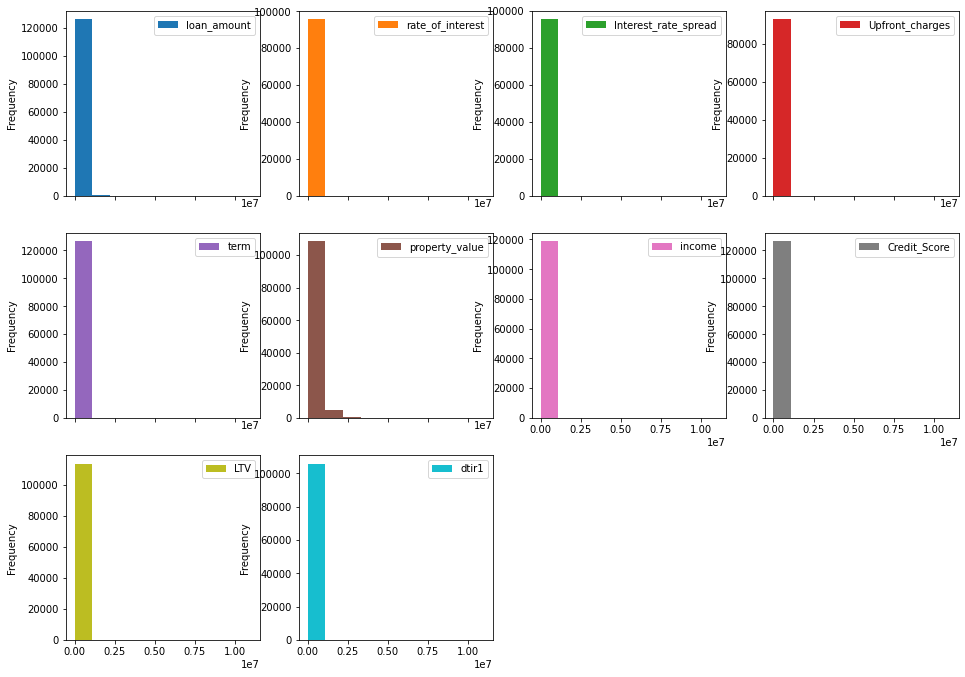

In [29]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

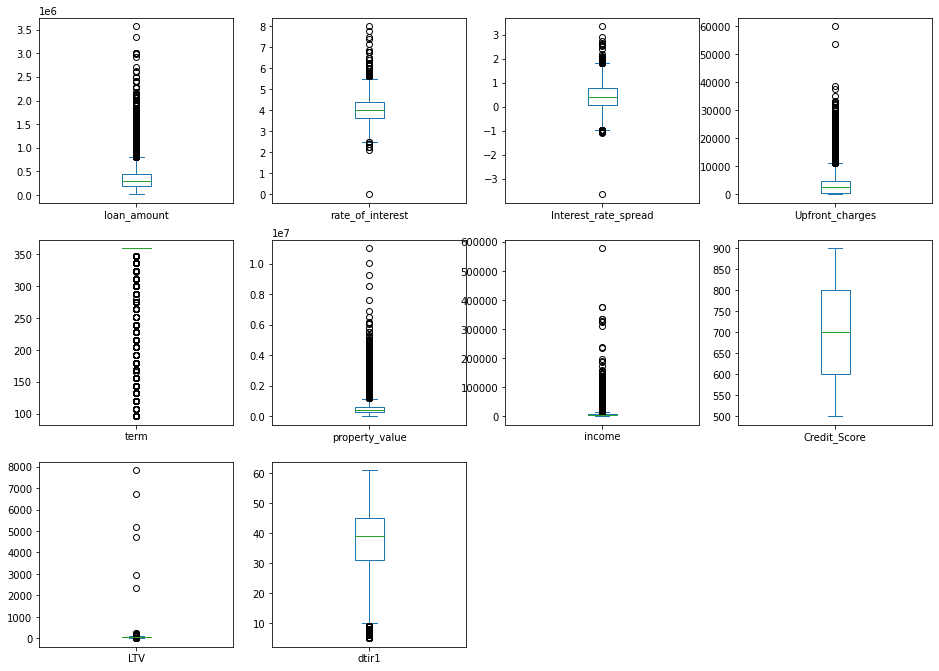

In [30]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

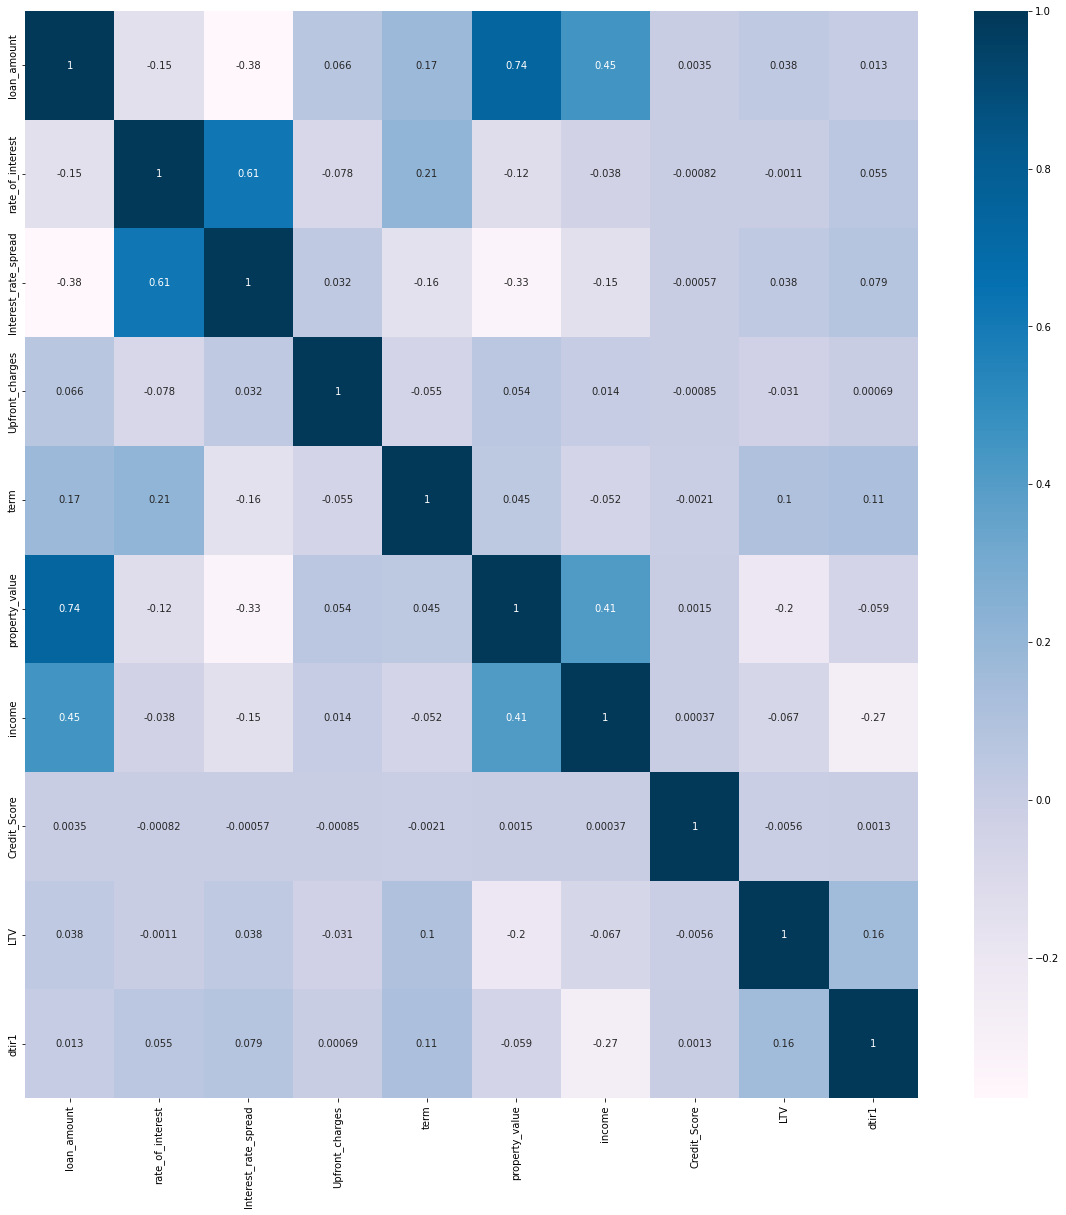

In [31]:
# Correlation matrix
fig = plt.figure(figsize=(20, 20))
correlations = df_features_train.corr(method='pearson')
sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
plt.show()

In [32]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [33]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [34]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy="constant", fill_value=0)),
    ('scaler', preprocessing.MinMaxScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool','category']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value='UKNOWN')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 10
Number of categorical columns: 21
Total number of columns in the feature dataframe: 31


In [35]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (126369, 31) to array_features_train.shape: (126369, 75)


### 3.b) Training Data Balancing

In [36]:
# Not applicable for this iteration of the project

### 3.c) Feature Selection

In [37]:
# Not applicable for this iteration of the project

### 3.d) Display the Final Datasets for Model-Building

In [38]:
# Finalize the training dataset for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
# label_encoder = preprocessing.LabelEncoder()
# array_target_train = label_encoder.fit_transform(df_target_train)
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (126369, 75) array_target_train.shape: (126369,)


In [39]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Tune Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [41]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=array_features_train.shape[1],
                    layer1_nodes=256, layer2_nodes=256, layer3_nodes=256,
                    layer1_dropout=0, layer2_dropout=0, layer3_dropout=0,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.Sequential([
        keras.layers.Dense(layer1_nodes, input_shape=(input_param,), activation='relu'),
        keras.layers.Dropout(layer1_dropout),
        keras.layers.Dense(layer2_nodes, activation='relu'),
        keras.layers.Dropout(layer2_dropout),
        keras.layers.Dense(layer3_nodes, activation='relu'),
        keras.layers.Dropout(layer3_dropout),
        keras.layers.Dense(1, activation=classifier_activation)
    ])
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [42]:
# start_time_module = datetime.now()
# reset_random()
# baseline_model = create_nn_model()
# baseline_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=1)
# print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

In [43]:
# Initialize the default model and get a baseline result
start_time_module = datetime.now()
results = list()
iteration = 0
cv = RepeatedKFold(n_splits=N_FOLDS, n_repeats=N_ITERATIONS, random_state=RNG_SEED)
for train_ix, val_ix in cv.split(array_features_train):
    feature_train, feature_validation = array_features_train[train_ix], array_features_train[val_ix]
    target_train, target_validation = array_target_train[train_ix], array_target_train[val_ix]
    reset_random()
    baseline_model = create_nn_model()
    baseline_model.fit(feature_train, target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
    model_metric = baseline_model.evaluate(feature_validation, target_validation, verbose=0)[1]
    iteration = iteration + 1
    print('Score from iteration %d >>> %.4f' % (iteration, model_metric))
    results.append(model_metric)
validation_score = np.mean(results)
validation_variance = np.std(results)
print('Average model score from all iterations: %.4f (%.4f)' % (validation_score, validation_variance))
print('Total time for model fitting and cross validating:', (datetime.now() - start_time_module))

2022-02-02 21:11:12.034032: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Score from iteration 1 >>> 1.0000
Score from iteration 2 >>> 1.0000
Score from iteration 3 >>> 1.0000
Score from iteration 4 >>> 1.0000
Score from iteration 5 >>> 1.0000
Average model score from all iterations: 1.0000 (0.0000)
Total time for model fitting and cross validating: 0:04:00.507338


### 4.b) Algorithm Tuning

In [44]:
# Not applicable for this iteration of the project

In [45]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Tune Models completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Make Predictions

In [46]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [47]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(array_features_train, array_target_train, epochs=MAX_EPOCHS, batch_size=BATCH_SIZE, verbose=0)
final_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               19456     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

### 5.b) Load Test Dataset and Make Predictions

In [48]:
# Finalize the test dataset for the testing activities
array_features_test = preprocessor.transform(df_features_test)
array_target_test = df_target_test.ravel()
print("array_features_test.shape: {} array_target_test.shape: {}".format(array_features_test.shape, array_target_test.shape))

array_features_test.shape: (22301, 75) array_target_test.shape: (22301,)


In [49]:
# Make batched predictions
test_predictions = (final_model.predict(array_features_test) > 0.5).astype("int32").ravel()
print(test_predictions)

[1 0 0 ... 0 0 1]


In [50]:
print('Accuracy Score:', accuracy_score(array_target_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(array_target_test, test_predictions), '\n')
print(confusion_matrix(array_target_test, test_predictions), '\n')
print(classification_report(array_target_test, test_predictions))

Accuracy Score: 1.0
ROC/AUC Score: 1.0 

[[16722     0]
 [    0  5579]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16722
           1       1.00      1.00      1.00      5579

    accuracy                           1.00     22301
   macro avg       1.00      1.00      1.00     22301
weighted avg       1.00      1.00      1.00     22301



In [51]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Make Predictions completed! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [52]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:05:07.596995
